In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import pyro
import pyro.contrib.gp as gp
import pyro.infer as infer
from pyro.contrib.examples.util import get_data_loader, get_data_directory


class ReluNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
relunn = ReluNN()

# Create deep kernel by warping RBF with CNN.
# CNN will transform a high dimension image into a low dimension 2D tensors for RBF kernel.
# This kernel accepts inputs are inputs of CNN and gives outputs are covariance matrix of RBF
# on outputs of CNN.
dotproduct = gp.kernels.Linear(input_dim=1)
deep_kernel = gp.kernels.Warping(dotproduct, iwarping_fn=relunn)

In [2]:
p=10
X=torch.rand(2000,p)*2-1
y=X[:,0]*X[:,1]+2**(X[:,2]+X[:,4]+X[:,5])+2**(X[:,2]+X[:,3]+X[:,4]+X[:,6])+torch.sin(X[:,6]*torch.sin(X[:,7]+X[:,8]))+torch.arccos(0.9*X[:,9])
y=y+torch.randn(2000)

In [3]:
gpr = gp.models.GPRegression(X, y, deep_kernel, noise=torch.tensor(0.1),jitter=1.0e-5)

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 1500 

start=time.time()
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i%30==0:
        print("epoch:",i,"train loss:",loss,"time:" ,time.time()-start)

epoch: 0 train loss: tensor(108493.5078, grad_fn=<AddBackward0>) time: 2.4269752502441406
epoch: 30 train loss: tensor(11834.5332, grad_fn=<AddBackward0>) time: 6.579121351242065
epoch: 60 train loss: tensor(8948.9834, grad_fn=<AddBackward0>) time: 10.491810083389282
epoch: 90 train loss: tensor(7761.0576, grad_fn=<AddBackward0>) time: 14.406564950942993
epoch: 120 train loss: tensor(6853.4482, grad_fn=<AddBackward0>) time: 18.15857696533203
epoch: 150 train loss: tensor(6021.7070, grad_fn=<AddBackward0>) time: 21.938365936279297
epoch: 180 train loss: tensor(5209.4766, grad_fn=<AddBackward0>) time: 25.90791130065918
epoch: 210 train loss: tensor(4405.1416, grad_fn=<AddBackward0>) time: 30.09409737586975
epoch: 240 train loss: tensor(3628.9351, grad_fn=<AddBackward0>) time: 34.09161567687988
epoch: 270 train loss: tensor(2941.1582, grad_fn=<AddBackward0>) time: 38.19806742668152
epoch: 300 train loss: tensor(2365.8740, grad_fn=<AddBackward0>) time: 42.12963533401489
epoch: 330 train lo

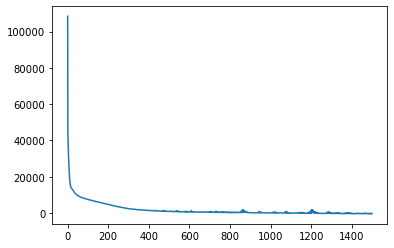

In [4]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [10]:
p=10
Xte=torch.rand(2000,p)*2-1
yte=Xte[:,0]*Xte[:,1]+2**(Xte[:,2]+Xte[:,4]+Xte[:,5])+2**(Xte[:,2]+Xte[:,3]+Xte[:,4]+Xte[:,6])+torch.sin(Xte[:,6]*torch.sin(Xte[:,7]+Xte[:,8]))+torch.arccos(0.9*Xte[:,9])
yte=yte+torch.randn(2000)

In [11]:
mean,cov = gpr(Xte,full_cov=True)

In [29]:
mseloss=torch.nn.MSELoss()
mseloss(mean,yte)

tensor(2.3817, grad_fn=<MseLossBackward>)